<a href="https://colab.research.google.com/github/pavansai26/google-coral-deployment-of-mobilenet-model/blob/master/deployment_of_mobilenet_model_in_google_coral_device.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip uninstall -y tensorflow
! pip install tf-nightly

In [ ]:
import tensorflow as tf
#assert tf.__version__.startswith('2.3')

import os
import numpy as np
import matplotlib.pyplot as plt

Prepare the training data
First let's download and organize the flowers dataset we'll use to retrain the model (it contains 5 flower classes).

Pay attention to this part so you can reproduce it with your own images dataset. In particular, notice that the "flower_photos" directory contains an appropriately-named directory for each class. The following code randomizes and divides up the photos into training and validation sets, and generates a labels file based on the photo folder names.

In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

flowers_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')


228818944/228813984 [==============================] - 4s 0us/step


Next, we use ImageDataGenerator to rescale the image data into float values (divide by 255 so the tensor values are between 0 and 1), and call flow_from_directory() to create two generators: one for the training dataset and one for the validation dataset.

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). For example, you can see the shapes here:

In [ ]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

Now save the class labels to a text file:

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('flower_labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [ ]:
!cat flower_labels.txt

daisy
dandelion
roses
sunflowers
tulips

Build the model
Now we'll create a model that's capable of transfer learning on just the last fully-connected layer.

We'll start with MobileNet V2 from Keras as the base model, which is pre-trained with the ImageNet dataset (trained to recognize 1,000 classes). This provides us a great feature extractor for image classification and we can then train a new classification layer with our flowers dataset.

Create the base model
When instantiating the MobileNetV2 model, we specify the include_top=False argument in order to load the network without the classification layers at the top. Then we set trainable false to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


Add a classification head
Now we create a new Sequential model and pass the frozen MobileNet model as the base of the graph, and append new classification layers so we can set the final output dimension to match the number of classes in our dataset (5 types of flowers).

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=5, activation='softmax')
])

Configure the model
Although this method is called compile(), it's basically a configuration step that's required before we can start training.

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

You can see a string summary of the final network with the summary() method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


And because the majority of the model graph is frozen in the base model, weights from only the last convolution and dense layers are trainable:

In [ ]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


Train the model
Now we can train the model using data provided by the train_generator and val_generator that we created at the beginning.

This should take less than 10 minutes.

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
46/46 [==============================] - 17s 368ms/step - loss: 0.7498 - accuracy: 0.7509 - val_loss: 0.4512 - val_accuracy: 0.8482
Epoch 2/10
46/46 [==============================] - 15s 331ms/step - loss: 0.2726 - accuracy: 0.9054 - val_loss: 0.3930 - val_accuracy: 0.8728
Epoch 3/10
46/46 [==============================] - 15s 328ms/step - loss: 0.1845 - accuracy: 0.9381 - val_loss: 0.3958 - val_accuracy: 0.8700
Epoch 4/10
46/46 [==============================] - 15s 326ms/step - loss: 0.1152 - accuracy: 0.9602 - val_loss: 0.4209 - val_accuracy: 0.8741
Epoch 5/10
46/46 [==============================] - 15s 326ms/step - loss: 0.0750 - accuracy: 0.9816 - val_loss: 0.5052 - val_accuracy: 0.8687
Epoch 6/10
46/46 [==============================] - 15s 326ms/step - loss: 0.0575 - accuracy: 0.9847 - val_loss: 0.5836 - val_accuracy: 0.8509
Epoch 7/10
46/46 [==============================] - 15s 326ms/step - loss: 0.0524 - accuracy: 0.9850 - val_loss: 0.5055 - val_accuracy: 0.8714

Review the learning curves

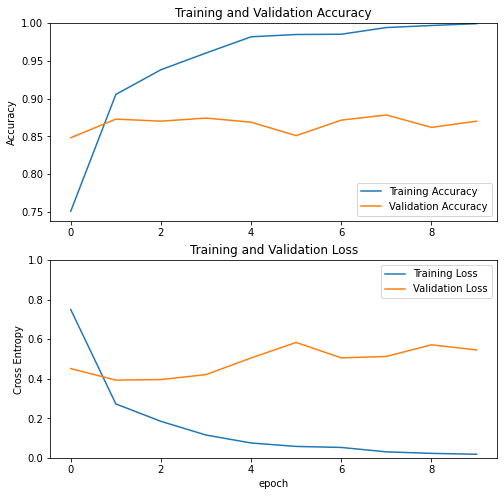

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tune the base model
So far, we've only trained the classification layers—the weights of the pre-trained network were not changed.

One way we can increase the accuracy is to train (or "fine-tune") more layers from the pre-trained model. That is, we'll un-freeze some layers from the base model and adjust those weights (which were originally trained with 1,000 ImageNet classes) so they're better tuned for features found in our flowers dataset.

Un-freeze more layers
So instead of freezing the entire base model, we'll freeze individual layers.

First, let's see how many layers are in the base model:

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


Let's try freezing just the bottom 100 layers.

In [ ]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Reconfigure the model
Now configure the model again, but this time with a lower learning rate (the default is 0.001).

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 60


Continue training
Now let's fine-tune all trainable layers. This starts with the weights we already trained in the classification layers, so we don't need as many epochs.

In [ ]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
46/46 [==============================] - 17s 376ms/step - loss: 0.4490 - accuracy: 0.8530 - val_loss: 0.5341 - val_accuracy: 0.8755
Epoch 2/5
46/46 [==============================] - 16s 347ms/step - loss: 0.2099 - accuracy: 0.9211 - val_loss: 0.5372 - val_accuracy: 0.8687
Epoch 3/5
46/46 [==============================] - 16s 348ms/step - loss: 0.1563 - accuracy: 0.9439 - val_loss: 0.5337 - val_accuracy: 0.8714
Epoch 4/5
46/46 [==============================] - 16s 350ms/step - loss: 0.1065 - accuracy: 0.9646 - val_loss: 0.5319 - val_accuracy: 0.8687
Epoch 5/5
46/46 [==============================] - 16s 350ms/step - loss: 0.0851 - accuracy: 0.9724 - val_loss: 0.5240 - val_accuracy: 0.8769


Review the new learning curves

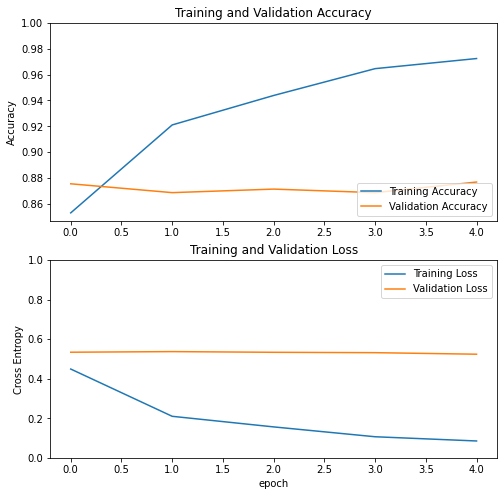

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This is better, but it's not ideal.

The validation loss is still higher than the training loss, so there could be some overfitting during training. The overfitting might also be because the new training set is relatively small with less intra-class variance, compared to the original ImageNet dataset used to train MobileNet V2.

So this model isn't trained to an accuracy that's production ready, but it works well enough as a demonstration.

Let's move on and convert the model to TensorFlow Lite.

Convert to TFLite
Ordinarily, creating a TensorFlow Lite model is just a few lines of code with TFLiteConverter. For example, this creates a basic (un-quantized) TensorFlow Lite model:

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpfomlkmqi/assets


However, this .tflite file still uses floating-point values for the parameter data, and we need to fully quantize the model to int8 format.

To fully quantize the model, we need to perform post-training quantization with a representative dataset, which requires a few more arguments for the TFLiteConverter, and a function that builds a dataset that's representative of the training dataset.

So let's convert the model again with post-training quantization:

In [ ]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(flowers_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# And this sets the representative dataset so we can quantize the activations
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpn3_5yiql/assets


INFO:tensorflow:Assets written to: /tmp/tmpn3_5yiql/assets


Compare the accuracy
So now we have a fully quantized TensorFlow Lite model. To be sure the conversion went well, let's evaluate both the raw model and the TensorFlow Lite model.

First check the accuracy of the raw model:

In [ ]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 87.500%


Now let's check the accuracy of the .tflite file, using the same dataset.

However, there's no convenient API to evaluate the accuracy of a TensorFlow Lite model, so this code runs several inferences and compares the predictions against ground truth:

In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 85.938%


You might see some, but hopefully not very much accuracy drop between the raw model and the TensorFlow Lite model. But again, these results are not suitable for production deployment.

Compile for the Edge TPU
Finally, we're ready to compile the model for the Edge TPU.

First download the Edge TPU Compiler:

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  28391      0 --:--:-- --:--:-- --:--:-- 28391
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [93.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learni

Then compile the model:

In [ ]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 2.1.302470888

Model compiled successfully in 591 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 3.08MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.11MiB
On-chip memory used for caching model parameters: 3.33MiB
On-chip memory remaining for caching model parameters: 4.39MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 73
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.


The compiled model uses the same filename but with "_edgetpu" appended at the end.

Download the model
You can download the converted model and labels file from Colab like this:

In [ ]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('flower_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If you get a "Failed to fetch" error here, it's probably because the files weren't done saving. So just wait a moment and try again.

Also look out for a browser popup that might need approval to download the files.

Run the model on the Edge TPU
You can now run the model on your Coral device with acceleration on the Edge TPU.

To get started, try using your .tflite model with this code for image classification with the TensorFlow Lite API.

Just follow the instructions on that page to set up your device, copy the mobilenet_v2_1.0_224_quant_edgetpu.tflite and flower_labels.txt files to your Coral Dev Board or device with a Coral Accelerator, and pass it a flower photo like this:

In [ ]:
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels flower_labels.txt \
  --input flower.jpg